# PHASE 2: Championship DNA & Success Analysis

## OBJECTIVE
To bridge the gap between defining what contributes to a successful play and what contributes to a Super Bowl winning team.  In Phase 1, we built a model to judge the quality of a single play.  In this phase we use that model to judge the quality of entire teams.

## METHODOLOGY
1. **Inference -> The Execution Grade**: We will run our trained XGBoost model on the entire dataset (2016-2025).
   - Since EPA can be reliant on the team/opponent played when calculating the EPA value, we will calculate **Success Over Expected (SOE)** for every play.  This separates performance from schedule luck.

2. **Aggregation -> The Team Genome**:
    - we will collapse 13,000+ plays into a concise Team Resume for every playoff contender.
    - Metrics will include: *Offensive SOE*, *Defensive Disruption*, *Pass/Run Efficiency*, *Situational Clutch Factors*

3. **Clustering -> The Archetypes**:
    - we will use **K-Means Clustering** to categorize teams into styles (e.g. Defensive Elite vs. Balanced Beasts)
  
4. **Correlations -> The Verdict**:
    - Finally, we will rank which traits have the highest correlation with **Playoff Rounds Advanced**.
    - Then we will compare these rankings against real historical playoff team results.  Do they match?
    - **Goal**: To produce a Top 10 list of statistical traits that define a Super Bowl champion team.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

In [2]:
# Load the model and data
artifacts = joblib.load('epa_success_model_v1.pkl')
model = artifacts['model']
features = artifacts['features']

df = pd.read_parquet('data/enriched_plays_v1.parquet')

## INFERENCE

In [3]:
# prepare for inference
X_inference = df[features].fillna(0)

# generate expected success (xSuccess)
df['x_success'] = model.predict_proba(X_inference)[:,1]

# calculate success over expected (SOE)
# SOE = Actual Result (1 or 0) - Expected Probability
df['soe'] = df['success'] - df['x_success']

# initial check: show the hardest and easiest plays the model has seen
print('Top 10 Hardest Successful Plays:')
print(df[df['success']==1].sort_values('x_success').head(10)[['season','posteam', 'defteam', 'x_success', 'soe']])

print('\nTop 10 Easiest Failed Plays:')
print(df[df['success']==0].sort_values('x_success', ascending=False).head(10)[['season','posteam', 'defteam', 'x_success', 'soe']])


Top 10 Hardest Successful Plays:
       season posteam defteam  x_success       soe
10977    2023     MIA      KC   0.031662  0.968338
5978     2020     BUF     IND   0.087673  0.912327
6957     2020     BUF      KC   0.093317  0.906683
3858     2018      NO      LA   0.103389  0.896611
3872     2018      NO      LA   0.111655  0.888345
2902     2018     IND     HOU   0.138017  0.861983
11911    2023     BAL      KC   0.141141  0.858859
11136    2023     BUF     PIT   0.142368  0.857632
11857    2023     DET      SF   0.160949  0.839051
6440     2020     BAL     BUF   0.166772  0.833228

Top 10 Easiest Failed Plays:
       season posteam defteam  x_success       soe
2339     2017      NE     TEN   0.857604 -0.857604
3752     2018      NO     PHI   0.854361 -0.854361
6561     2020     CLE      KC   0.832760 -0.832760
6739     2020      TB      NO   0.831974 -0.831974
6298     2020      TB     WAS   0.828490 -0.828490
8044     2021      KC     BUF   0.820315 -0.820315
10210    2022      

## AGGREGATION

In [4]:
# load nflreadpy pbp data since 'epa' is not included in our model dataset
import nflreadpy as nfl

seasons = list(range(2016, 2026))

pbp_data = nfl.load_pbp(seasons)

pbp_data = pbp_data.to_pandas()


In [5]:
pbp_data = pbp_data[['play_id', 'posteam', 'defteam', 'season', 'season_type', 'epa', 'success']].copy()

In [6]:
pbp_data.head()

,play_id,posteam,defteam,season,season_type,epa,success
0,1.0,None,None,2016,REG,0.000000,0.0
1,36.0,BAL,BUF,2016,REG,-0.955114,0.0
2,58.0,BAL,BUF,2016,REG,0.336466,1.0
3,85.0,BAL,BUF,2016,REG,0.644540,1.0
4,109.0,BAL,BUF,2016,REG,-0.546209,0.0


In [7]:
pbp_data[(pbp_data['season'] == 2025) & (pbp_data['season_type'] == 'POST')].head(10)

,play_id,posteam,defteam,season,season_type,epa,success
481935,1.0,None,None,2025,POST,0.000000,0.0
481936,39.0,JAX,BUF,2025,POST,0.579015,1.0
481937,62.0,JAX,BUF,2025,POST,-1.077002,0.0
481938,84.0,JAX,BUF,2025,POST,-0.094944,0.0
481939,109.0,JAX,BUF,2025,POST,-1.477439,0.0
481940,132.0,JAX,BUF,2025,POST,0.938485,1.0
481941,152.0,BUF,JAX,2025,POST,-0.385257,0.0
481942,174.0,BUF,JAX,2025,POST,-0.708665,0.0
481943,199.0,BUF,JAX,2025,POST,2.010296,1.0
481944,229.0,BUF,JAX,2025,POST,-0.943040,0.0


In [10]:
# merge df with pbp_data so we can use epa in aggregations
df = df.merge(
    pbp_data[['play_id', 'season', 'epa']],
    on=['play_id', 'season'],
    how='left'
)

In [11]:
# 1. Offensive Profile

offense_profile = df.groupby(['season', 'posteam']).agg(
    n_plays=('play_id', 'count'),
    off_soe=('soe', 'mean'),
    off_x_success=('x_success', 'mean'),
    off_epa=('epa', 'mean')
).reset_index()

# convert soe to percent
offense_profile['off_soe'] *= 100
offense_profile['off_soe'] = offense_profile['off_soe'].round(2)
offense_profile['off_epa'] = offense_profile['off_epa'].round(2)

# 2. Defensive Profile

defense_profile = df.groupby(['season', 'defteam']).agg(
    def_soe=('soe', 'mean'),
    def_epa=('epa', 'mean')
).reset_index()

# convert soe to percent
defense_profile['def_soe'] *= 100
defense_profile['def_soe'] = defense_profile['def_soe'].round(2)
defense_profile['def_epa'] = defense_profile['def_epa'].round(2)

# rename defteam to posteam to merge
defense_profile.rename(columns={'defteam': 'posteam'}, inplace=True)

# merge into team_genome dataframe
team_genome = offense_profile.merge(defense_profile, on=['season', 'posteam'])

# View most successful offenses of the era 2016-2025
print('Top 10 Most Successful Postseason Offenses (by SOE) 2016-2025')
print(team_genome.sort_values('off_soe', ascending=False).head(10)[['season', 'posteam', 'off_soe', 'off_epa']])

print('Top 10 Most Successful Postseason Defenses (by SOE) 2016-2025')
print(team_genome.sort_values('def_soe', ascending=True).head(10)[['season', 'posteam', 'def_soe', 'def_epa']])

Top 10 Most Successful Postseason Offenses (by SOE) 2016-2025
     season posteam  off_soe  off_epa
46     2019      SF    56.45     0.11
92     2023     CLE    53.95     0.00
38     2019      GB    42.11     0.11
26     2018     DAL    39.44     0.02
69     2021      LV    30.14    -0.22
106    2024     DEN    28.36     0.02
37     2019     BUF    28.28     0.11
111    2024      LA    20.89     0.03
116    2024      TB    19.00     0.04
19     2017      NE    17.14    -0.08
Top 10 Most Successful Postseason Defenses (by SOE) 2016-2025
     season posteam  def_soe  def_epa
5      2016      KC   -48.93     0.03
93     2023     DAL   -48.53     0.00
104    2024     BAL   -45.87     0.02
27     2018     HOU   -40.84     0.04
100    2023     PHI   -33.58    -0.12
51     2020     CLE   -31.74    -0.00
102    2023      SF   -27.88     0.00
6      2016      LV   -27.14    -0.03
81     2022      KC   -26.77    -0.02
103    2023      TB   -25.64    -0.00


In [12]:
# look at Eagles team off_soe and def_soe from 2016-2025

eagles_off_def = team_genome[team_genome['posteam'] == 'PHI']

print('Eagles Offensive & Defensive SOE by Postseason 2016-2025')
print(eagles_off_def[['season', 'off_soe', 'off_epa', 'def_soe', 'def_epa']].sort_values('season'))


Eagles Offensive & Defensive SOE by Postseason 2016-2025
     season  off_soe  off_epa  def_soe  def_epa
21     2017    -2.39    -0.05    12.28    -0.05
34     2018   -15.32     0.04    -8.98     0.02
44     2019   -11.85    -0.02    -6.82     0.12
71     2021    -4.68    -0.17     7.53     0.09
86     2022   -22.79    -0.02    -9.86    -0.01
100    2023    -5.97    -0.05   -33.58    -0.12
114    2024    -1.45     0.01    -6.13     0.01


In [13]:
rams_off_def = team_genome[team_genome['posteam'] == 'LA']

print('Rams Offensive & Defensive SOE by Postseason 2016-2024')
print(rams_off_def[['season', 'off_soe', 'off_epa', 'def_soe', 'def_epa']].sort_values('season'))

Rams Offensive & Defensive SOE by Postseason 2016-2024
     season  off_soe  off_epa  def_soe  def_epa
17     2017    -8.92    -0.06    -6.67    -0.01
30     2018    -5.57    -0.01   -13.99     0.01
55     2020   -18.66     0.04     1.42     0.01
68     2021    -7.30     0.00   -15.56    -0.16
98     2023    -4.24     0.07    40.69    -0.02
111    2024    20.89     0.03    -4.70     0.02


### CLUSTERING TO DEFINE TEAM ARCHETYPES

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# select the features that define a team's style of play (off_soe, off_epa, def_soe, def_epa)
features = ['off_soe', 'off_epa', 'def_soe', 'def_epa']

# scale the data 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(team_genome[features])

# fit the KMeans model on 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
team_genome['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze cluster centers
cluster_centers = team_genome.groupby('cluster')[features].mean()

print('The 4 Playoff Team Archetypes')
print(cluster_centers.round(3))

sb_losers = {
    '2016': 'ATL',
    '2017': 'NE',
    '2018': 'LA',
    '2019': 'SF',
    '2020': 'KC',
    '2021': 'CIN',
    '2022': 'PHI',
    '2023': 'SF',
    '2024': 'KC'
}

sb_winners = {
    '2016': 'NE',
    '2017': 'PHI',
    '2018': 'NE',
    '2019': 'KC',
    '2020': 'TB',
    '2021': 'LA',
    '2022': 'KC',
    '2023': 'KC',
    '2024': 'PHI'
}



print('\nTeams in Each Cluster')
print('(* = Super Bowl Winner | # = Super Bowl Loser)\n')

for c in range(4):
    print(f"Cluster {c}:")
    teams = team_genome[team_genome['cluster'] == c].head(40)[['season', 'posteam']]
    
    team_strings = []
    for _, row in teams.iterrows():
        year_str = str(row['season'])
        team = row['posteam']
        
        # Determine the marker (* for winner, # for loser)
        marker = ""
        if sb_winners.get(year_str) == team:
            marker = "*"
        elif sb_losers.get(year_str) == team:
            marker = "#"
            
        # Format as [Year TeamMarker]
        team_strings.append(f"[{year_str} {team}{marker}]")
    
    # Print them out in chunks of 8 per line, separated by commas
    for i in range(0, len(team_strings), 8):
        print("  " + ", ".join(team_strings[i:i+8]))
    print()

The 4 Playoff Team Archetypes
         off_soe  off_epa  def_soe  def_epa
cluster                                    
0         -8.066    0.021   -9.062    0.006
1         33.374    0.052    3.337    0.056
2        -12.214   -0.018   17.886    0.051
3         -4.031   -0.076   -6.218   -0.049

Teams in Each Cluster
(* = Super Bowl Winner | # = Super Bowl Loser)

Cluster 0:
  [2016 ATL#], [2016 DAL], [2016 DET], [2016 GB], [2016 HOU], [2016 KC], [2016 NYG], [2016 SEA]
  [2017 PIT], [2018 CHI], [2018 HOU], [2018 IND], [2018 KC], [2018 LA#], [2018 LAC], [2018 NE*]
  [2018 NO], [2018 PHI], [2019 BAL], [2019 KC*], [2019 MIN], [2019 NO], [2019 TEN], [2020 BAL]
  [2020 BUF], [2020 CHI], [2020 CLE], [2020 GB], [2020 KC#], [2020 LA], [2020 NO], [2020 SEA]
  [2020 TB*], [2020 TEN], [2020 WAS], [2021 BUF], [2021 DAL], [2021 PIT], [2021 SF], [2022 BUF]

Cluster 1:
  [2018 DAL], [2019 BUF], [2019 GB], [2019 SF#], [2023 CLE], [2024 DEN], [2024 DET], [2024 LA]
  [2024 TB]

Cluster 2:
  [2016 MIA], [2

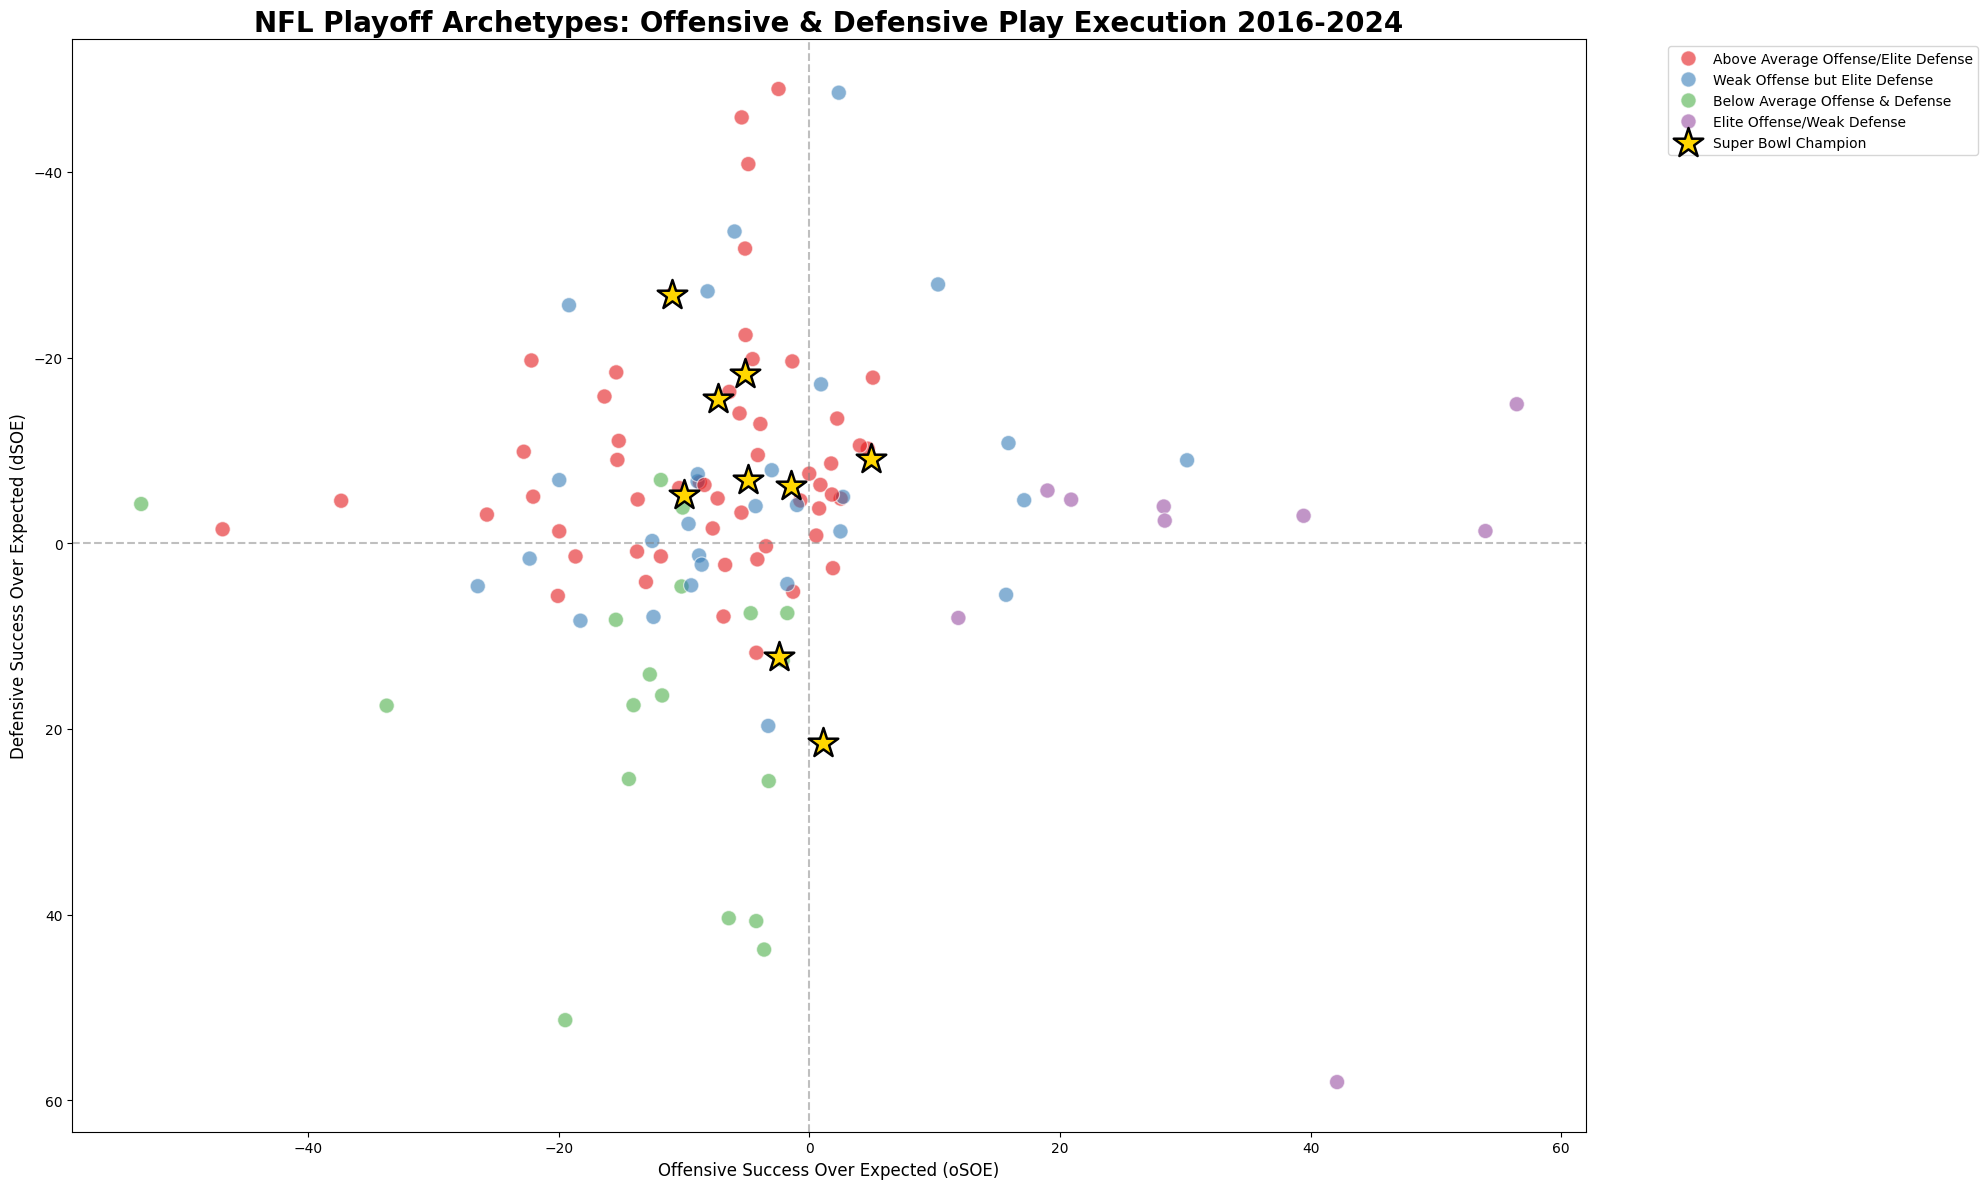

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# map archetypes to clusters

cluster_names = {
    0: 'Above Average Offense/Elite Defense',
    1: 'Elite Offense/Weak Defense',
    2: 'Below Average Offense & Defense',
    3: 'Weak Offense but Elite Defense'
}

team_genome['Archetype'] = team_genome['cluster'].map(cluster_names)

# setup plot
plt.figure(figsize=(20, 12))

sns.scatterplot(
    data=team_genome,
    x='off_soe',
    y='def_soe',
    hue='Archetype',
    palette='Set1',
    s=120,
    alpha=0.6
)

# Idenitfy and highlight super bowl winners with a gold star
winners_df = team_genome[
    team_genome.apply(lambda row: sb_winners.get(str(row['season'])) == row['posteam'], axis=1)
]

sns.scatterplot(
    data=winners_df,
    x='off_soe',
    y='def_soe',
    color='gold',
    edgecolor='black',
    marker='*',
    s=500,
    label='Super Bowl Champion',
    zorder=5
)

# format the chart
plt.gca().invert_yaxis()
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

plt.title('NFL Playoff Archetypes: Offensive & Defensive Play Execution 2016-2024', fontweight='bold', fontsize=20)
plt.xlabel('Offensive Success Over Expected (oSOE)', fontsize=12)
plt.ylabel('Defensive Success Over Expected (dSOE)', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()